# **Notebook 5: Regression with Original Untreated Dataset**

## Objectives

* To develop machine learning regression models for the continuous numerical target feature
* To identify the most important feature through feature assessment
* To develop a machine learning classification model for the a categorical target feature
* To find the best model and pipeline for predicting houseprices

## Inputs

* The original dataset that has not been subject to feature engineering in Notebook 2 and Notebook 4:
('inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv')

## Outputs

* A pipeline for predicting houeprices
* Data on feature importance
* Datasets for modelling as part of the app

## Additional Comments
*This notebook develops machine learning models with the original dataset, before using the best model and pipeline with the transformed and feature engineered dataset in Notebook 7 


---

## Change working directory

In [91]:
import os

# Get the current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Change the directory to the new path
os.chdir('/workspace/milestone-project-housing-issues')

# Get the updated current directory
current_dir = os.getcwd()
print("New Current Directory:", current_dir)

Current Directory: /workspace/milestone-project-housing-issues
New Current Directory: /workspace/milestone-project-housing-issues


### Switching off Future Proofing warnings for the Notebook for improved legibility


In [92]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Load dataset

In [138]:
# Loading original dataset and dropping columns with >80% missing data
import pandas as pd

df_houseprices_regression = pd.read_csv(
    '/workspace/milestone-project-housing-issues/inputs/datasets/raw/'
    'house-price-20211124T154130Z-001/house-price/house_prices_records.csv'
).drop(['EnclosedPorch', 'WoodDeckSF'], axis=1)

print(df_houseprices_regression.shape)
df_houseprices_regression.head()


(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


In [94]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1374 non-null   float64
 2   BedroomAbvGr  1361 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1346 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1298 non-null   object 
 9   GarageYrBlt   1379 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1201 non-null   float64
 14  MasVnrArea    1452 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

---

## Checking Missing Data

In [95]:
#Using EvaluateMissingData() function to display missing data
def EvaluateMissingData(df_houseprices_regression):
  missing_data_absolute = df_houseprices_regression.isnull().sum()
  missing_data_percentage = round(missing_data_absolute/len(df_houseprices_regression)*100, 2)
  df_missing_data = (pd.DataFrame(
              data={"RowsWithMissingData": missing_data_absolute,
                  "PercentageOfDataset": missing_data_percentage,
                  "DataType": df_houseprices_regression.dtypes}
                  )
             .sort_values(by=['PercentageOfDataset'], ascending=False)
             .query("PercentageOfDataset > 0")
             )

  return df_missing_data

EvaluateMissingData(df_houseprices_regression)

,RowsWithMissingData,PercentageOfDataset,DataType
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [139]:
# Recoding missing data using random sampling from the distribution
# for LotFrontage, GarageFinish, BsmtFinType1, BedroomAbvGr, 2ndFlrSF, GarageYrBlt, MasVnrArea
import numpy as np

columns_to_impute = [
    'LotFrontage', 'GarageFinish', 'BsmtFinType1', 'BedroomAbvGr',
    '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'
]

# Applying random sampling from the distribution for each specified column
for col in columns_to_impute:
    df_houseprices_regression[col] = df_houseprices_regression[col].apply(
        lambda x: np.random.choice(df_houseprices_regression[col].dropna())
        if pd.isnull(x) else x
    )



In [97]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

In [98]:
missing_values_count = df_houseprices_regression.isna().sum()
missing_values_count

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

---

## ML Pipeline: Regressor

### ML Pipeline

In [99]:
# Code from the Code Institute Churnometer walkthrough project
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    
    categorical_vars = X_train.select_dtypes(include=['object']).columns.tolist()

    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=categorical_vars)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])
    return pipeline_base

In [100]:
df_houseprices_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

### Hyperparameter Optimisation

In [101]:
# Code from the Code Institute Churnometer walkthrough project
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


### Split Train Test Set

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprices_regression.drop(['SalePrice'], axis=1),
    df_houseprices_regression['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Grid Search CV - Sklearn

In [103]:
# Model search with Grid Search CV
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [104]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [105]:
import numpy as np

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804354,0.874444,0.07169
0,LinearRegression,0.709764,0.79994,0.840018,0.046761
5,GradientBoostingRegressor,0.635656,0.758993,0.820849,0.064068
4,AdaBoostRegressor,0.621051,0.745214,0.794568,0.062934
2,RandomForestRegressor,0.664235,0.741188,0.817394,0.056797
6,XGBRegressor,0.516199,0.637356,0.711843,0.072758
1,DecisionTreeRegressor,0.495511,0.575796,0.669601,0.064638


### Search with most suitable model to find the best hyperparameters

In [140]:
models_search_regressor = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search_regressor = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],  # Number of trees
        'model__max_depth': [3, 10, None],  # Maximum depth of each tree
        'model__min_samples_split': [2, 5],  # Minimum samples required to split a node
        'model__min_samples_leaf': [1, 4],  # Minimum samples required at a leaf node
        'model__max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
    }
}

params_quick_search_regressor = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 4],
        'model__max_features': ['auto', 'sqrt'],
    }
}


In [107]:
search = HyperparameterOptimizationSearch(models=models_search_regressor, params=params_search_regressor)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [108]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
39,ExtraTreesRegressor,0.773261,0.831803,0.875627,0.039258,None,auto,4,5,300
37,ExtraTreesRegressor,0.773261,0.831803,0.875627,0.039258,None,auto,4,2,300
38,ExtraTreesRegressor,0.770705,0.831688,0.878759,0.041045,None,auto,4,5,100
36,ExtraTreesRegressor,0.770705,0.831688,0.878759,0.041045,None,auto,4,2,100
23,ExtraTreesRegressor,0.771963,0.830523,0.875151,0.038402,10,auto,4,5,300
21,ExtraTreesRegressor,0.771963,0.830523,0.875151,0.038402,10,auto,4,2,300
20,ExtraTreesRegressor,0.770815,0.830442,0.876097,0.039479,10,auto,4,2,100
22,ExtraTreesRegressor,0.770815,0.830442,0.876097,0.039479,10,auto,4,5,100
43,ExtraTreesRegressor,0.724212,0.825335,0.880357,0.056302,None,sqrt,1,5,300
41,ExtraTreesRegressor,0.70908,0.82303,0.878834,0.060482,None,sqrt,1,2,300


---

### Best model and hyperparameters

In [109]:
best_model_regressor = grid_search_summary.iloc[0, 0]
best_model_regressor

'ExtraTreesRegressor'

In [110]:
best_params_regressor = grid_search_pipelines[best_model_regressor].best_params_
best_params_regressor

{'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

#### Best regressor pipeline

In [111]:
best_regressor_pipeline = grid_search_pipelines[best_model_regressor].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFront

---

### Assessing feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']


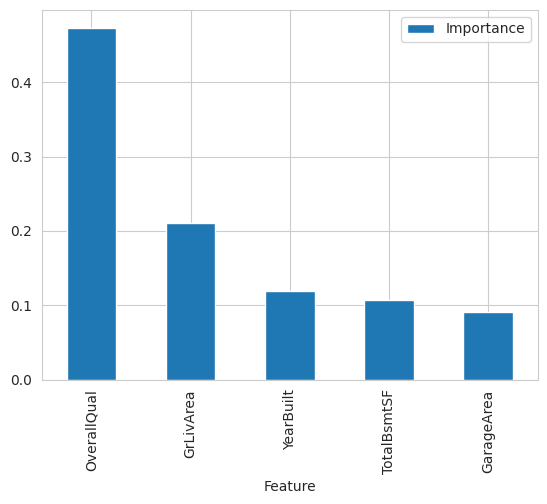

In [112]:
# Code from the Code Institute Churnometer walkthrough project
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


---

## Evaluate on Train and Test Sets

In [113]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.897
Mean Absolute Error: 15658.157
Mean Squared Error: 633206482.536
Root Mean Squared Error: 25163.594


* Test Set
R2 Score: 0.799
Mean Absolute Error: 20606.039
Mean Squared Error: 1391233259.205
Root Mean Squared Error: 37299.239




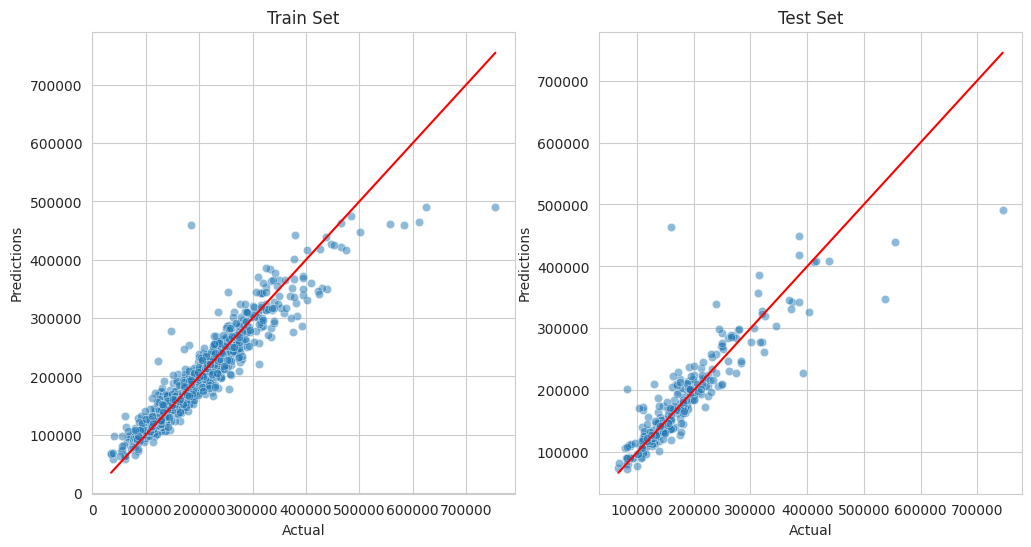

In [114]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

## Regressor with PCA

In [115]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df_houseprices_regression.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'numpy.ndarray'>


#### Applying PCA to the scaled data

* The 17 components explain 100.0% of the data 



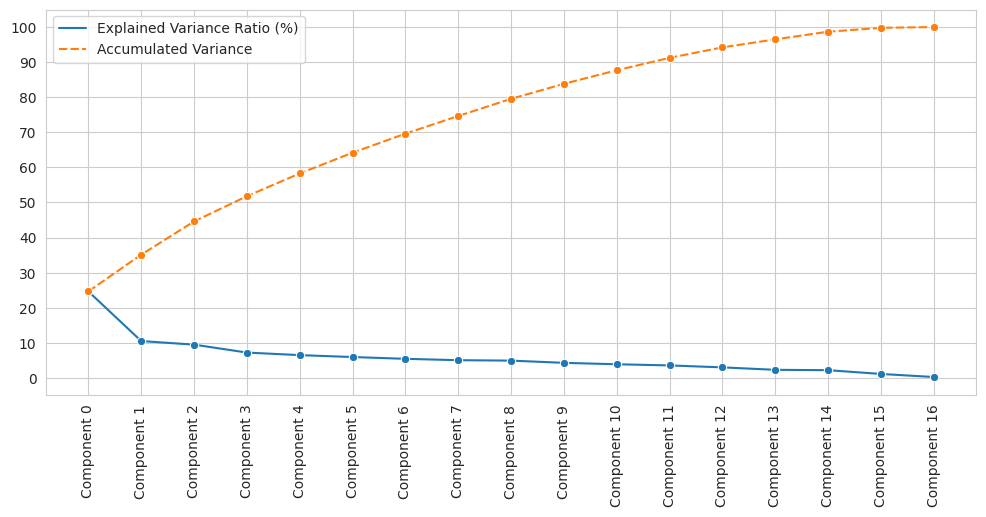

In [141]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = [
        "Component " + str(number) for number in range(n_components)
    ]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)']
    )

    dfExplVarRatio['Accumulated Variance'] = (
        dfExplVarRatio['Explained Variance Ratio (%)'].cumsum()
    )

    PercentageOfDataExplained = (
        dfExplVarRatio['Explained Variance Ratio (%)'].sum()
    )

    print(
        f"* The {n_components} components explain "
        f"{round(PercentageOfDataExplained, 2)}% of the data \n"
    )
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio, marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


* The 9 components explain 79.53% of the data 



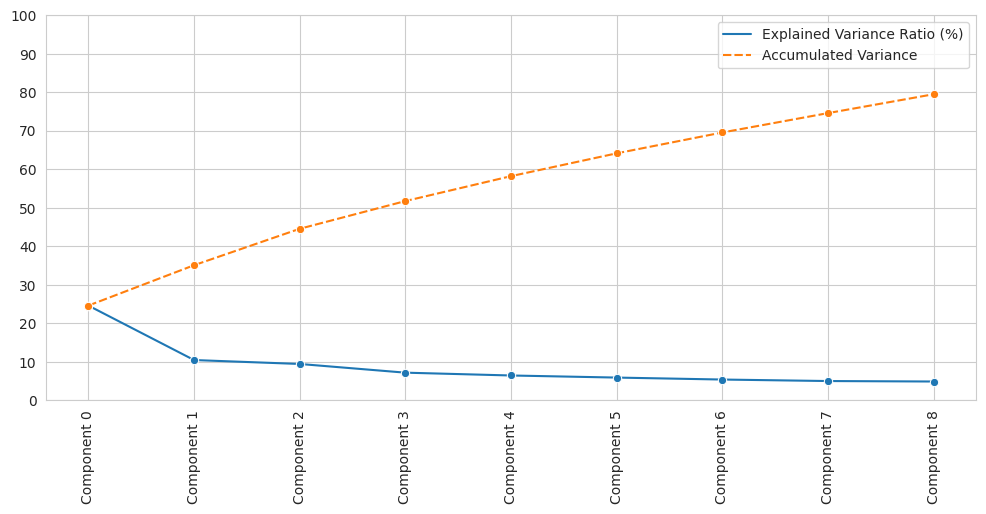

In [117]:
n_components = 9
pca_components_analysis(df_pca=df_pca, n_components=n_components)

### Rewriting ML Pipeline for Modelling

In [118]:
# PCA
from sklearn.decomposition import PCA

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1',
                                                                'GarageFinish', 'KitchenQual'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replaces Feature Selection
        ("PCA", PCA(n_components=9, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

In [119]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


In [120]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [121]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in

In [122]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.664662,0.793916,0.839247,0.065493
2,RandomForestRegressor,0.733803,0.793599,0.82392,0.032791
5,GradientBoostingRegressor,0.703819,0.783214,0.826817,0.04206
0,LinearRegression,0.678295,0.779885,0.836434,0.054273
6,XGBRegressor,0.669257,0.767785,0.827084,0.052764
4,AdaBoostRegressor,0.692633,0.735099,0.778321,0.028323
1,DecisionTreeRegressor,0.596686,0.648515,0.7303,0.046376


### Extensive search on the most suitable model to find the best hyperparameters

In [123]:
models_search_pca = {
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

params_search_pca = {
    "RandomForestRegressor":{
        'model__n_estimators': [100, 300],
        'model__max_depth': [3, 10, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 4],
        'model__max_features': ['auto', 'sqrt'],
    }
}

In [124]:
search = HyperparameterOptimizationSearch(models=models_search_pca, params=params_search_pca)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [125]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
34,RandomForestRegressor,0.746357,0.797847,0.828341,0.029314,None,auto,1,5,100
35,RandomForestRegressor,0.743435,0.79694,0.824899,0.029572,None,auto,1,5,300
38,RandomForestRegressor,0.757619,0.796293,0.818636,0.022292,None,auto,4,5,100
36,RandomForestRegressor,0.757619,0.796293,0.818636,0.022292,None,auto,4,2,100
39,RandomForestRegressor,0.757859,0.79623,0.817942,0.021903,None,auto,4,5,300
37,RandomForestRegressor,0.757859,0.79623,0.817942,0.021903,None,auto,4,2,300
17,RandomForestRegressor,0.740253,0.796078,0.824245,0.03048,10,auto,1,2,300
33,RandomForestRegressor,0.735574,0.795909,0.825809,0.032976,None,auto,1,2,300
20,RandomForestRegressor,0.757409,0.795762,0.817831,0.02211,10,auto,4,2,100
22,RandomForestRegressor,0.757409,0.795762,0.817831,0.02211,10,auto,4,5,100


### Best model and hyperparameters:

In [126]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'RandomForestRegressor'

In [127]:
best_params_pca = grid_search_pipelines[best_model_pca].best_params_
best_params_pca

{'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 100}

In [128]:
best_regressor_pca_pipeline = grid_search_pipelines[best_model_pca].best_estimator_
best_regressor_pca_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
       

## Evaluating Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.964
Mean Absolute Error: 9164.313
Mean Squared Error: 223790745.665
Root Mean Squared Error: 14959.637


* Test Set
R2 Score: 0.813
Mean Absolute Error: 20776.78
Mean Squared Error: 1290414464.816
Root Mean Squared Error: 35922.339




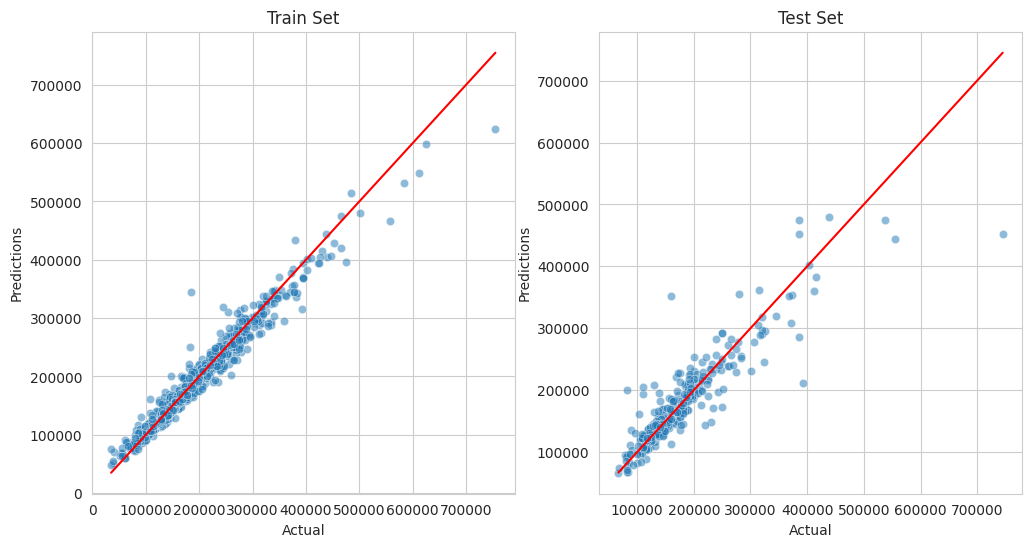

In [129]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pca_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pca_pipeline)

---

# Converting Target to Categorical for Classification Analysis

* The classes represent the following ranges: 
{'SalePrice': [-inf, 129975.0, 163000.0, 214000.0, inf]} 



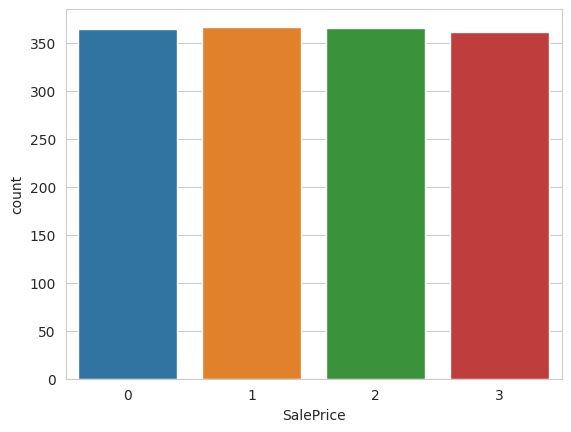

In [130]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=4, variables=['SalePrice'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df_houseprices_regression)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='SalePrice')
plt.show()

In [131]:
df_clf.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,2
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,2
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,3


In [132]:
df_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   float64
 2   BedroomAbvGr  1460 non-null   float64
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

### Rewriting ML Pipeline for modelling

#### Algorithms for classification analysis

In [133]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [134]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        (
            "OrdinalCategoricalEncoder",
            OrdinalEncoder(
                encoding_method='arbitrary',
                variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
            )
        ),
        (
            "SmartCorrelatedSelection",
            SmartCorrelatedSelection(
                variables=None, method="spearman",
                threshold=0.6, selection_method="variance"
            )
        ),
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base


### Splitting Train and Test Sets

In [135]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


### Grid Seach CV – Sklearn

In [136]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [137]:
# Setting classification metrics for model
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

KeyboardInterrupt: 

In [48]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,GradientBoostingClassifier,0.724138,0.775862,0.862069,0.05342
2,RandomForestClassifier,0.689655,0.772414,0.810345,0.044159
4,ExtraTreesClassifier,0.62069,0.751724,0.827586,0.071172
5,AdaBoostClassifier,0.706897,0.737931,0.793103,0.033432
0,XGBClassifier,0.62069,0.7,0.810345,0.06226
1,DecisionTreeClassifier,0.551724,0.644828,0.706897,0.063208


### Extensive search on hyperparameters

In [49]:
models_search_clf = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

params_search_clf = {
    "GradientBoostingClassifier":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

In [50]:
search = HyperparameterOptimizationSearch(models=models_search_clf, params=params_search_clf)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators
0,GradientBoostingClassifier,0.729682,0.747917,0.762306,0.011729,0.1,3,100
1,GradientBoostingClassifier,0.661248,0.732871,0.775888,0.038091,0.1,3,300
7,GradientBoostingClassifier,0.684192,0.730248,0.769097,0.027101,0.01,3,300
3,GradientBoostingClassifier,0.711358,0.729538,0.752119,0.014864,0.1,10,300
2,GradientBoostingClassifier,0.671513,0.717246,0.752119,0.032033,0.1,10,100
6,GradientBoostingClassifier,0.660436,0.683963,0.726261,0.022846,0.01,3,100
9,GradientBoostingClassifier,0.640717,0.681759,0.73514,0.042411,0.01,10,300
13,GradientBoostingClassifier,0.599315,0.643701,0.70458,0.034914,0.001,3,300
8,GradientBoostingClassifier,0.585714,0.628666,0.724954,0.049868,0.01,10,100
12,GradientBoostingClassifier,0.579126,0.609645,0.653645,0.027531,0.001,3,100


### Best model and hyperparameters

In [52]:
best_model_clf = grid_search_summary.iloc[0,0]
best_model_clf

'GradientBoostingClassifier'

In [53]:
best_params_clf = grid_search_pipelines[best_model_clf].best_params_
best_params_clf

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

In [54]:
pipeline_clf = grid_search_pipelines[best_model_clf].best_estimator_
pipeline_clf

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'Lot

---

### Assessing feature importance

* These are the 5 most important features in descending order. The model was trained on them: 
['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']


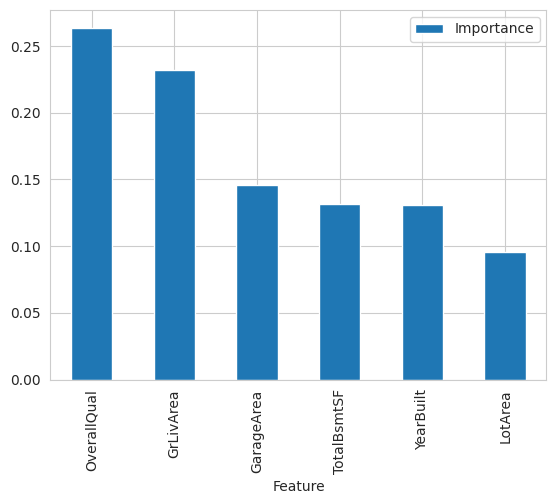

In [55]:
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features_clf = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance_clf = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features_clf = df_feature_importance_clf['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance_clf.plot(kind='bar', x='Feature', y='Importance')
plt.show()


---

## Evaluate classifier on train and test sets

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X, y, pipeline_clf, label_map):

    prediction = pipeline_clf.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [57]:
disc.binner_dict_['SalePrice']

[-inf, 129975.0, 163000.0, 214000.0, inf]

In [58]:
label_map = ['129,975 and under', '129,975 to 163,000', '163,000 to 214,000', '214,000 and over']
label_map

['129,975 and under',
 '129,975 to 163,000',
 '163,000 to 214,000',
 '214,000 and over']

In [59]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

#### Train Set #### 

---  Confusion Matrix  ---
                              Actual 129,975 and under  \
Prediction 129,975 and under                       270   
Prediction 129,975 to 163,000                       18   
Prediction 163,000 to 214,000                        2   
Prediction 214,000 and over                          0   

                              Actual 129,975 to 163,000  \
Prediction 129,975 and under                         13   
Prediction 129,975 to 163,000                       269   
Prediction 163,000 to 214,000                        14   
Prediction 214,000 and over                           1   

                              Actual 163,000 to 214,000  \
Prediction 129,975 and under                          0   
Prediction 129,975 to 163,000                        12   
Prediction 163,000 to 214,000                       264   
Prediction 214,000 and over                           7   

                              Actual 214,000 and over  
Prediction 1

---

# Identifying Best Pipeline

We fitted 3 pipelines fitted:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [60]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'Lot

---

## Refit pipeline with best features

### Rewrite Pipeline with features identified in general (first) regressor feature assessment

In [61]:
# Recoded PipelineOptimization function for numerical variables
def PipelineOptimization_numerical(model):

    pipeline_base = Pipeline([

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', 'TotalBsmtSF'],
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("model", model),
    ])
    return pipeline_base

In [62]:
df_houseprices_best_model = df_houseprices_regression[['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'SalePrice']]
df_houseprices_best_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   GrLivArea    1460 non-null   int64
 2   GarageArea   1460 non-null   int64
 3   TotalBsmtSF  1460 non-null   int64
 4   YearBuilt    1460 non-null   int64
 5   SalePrice    1460 non-null   int64
dtypes: int64(6)
memory usage: 68.6 KB


### Split Train and Test Sets

In [63]:
df_houseprices_best_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   GrLivArea    1460 non-null   int64
 2   GarageArea   1460 non-null   int64
 3   TotalBsmtSF  1460 non-null   int64
 4   YearBuilt    1460 non-null   int64
 5   SalePrice    1460 non-null   int64
dtypes: int64(6)
memory usage: 68.6 KB


In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df_houseprices_best_model.drop(['SalePrice'], axis=1),
    df_houseprices_best_model['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


In [65]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 5) (1168,) 
* Test set: (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921


In [66]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   GarageArea   1168 non-null   int64
 1   GrLivArea    1168 non-null   int64
 2   OverallQual  1168 non-null   int64
 3   TotalBsmtSF  1168 non-null   int64
 4   YearBuilt    1168 non-null   int64
dtypes: int64(5)
memory usage: 54.8 KB


### Grid Search CV – Sklearn

In [68]:
models_search_regressor

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [69]:
params_search_regressor = {'ExtraTreesRegressor':  {
    'model__n_estimators': [100, 300],
    'model__max_depth': [3, 10, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 4],
    'model__max_features': ['auto', 'sqrt'],
}
}
params_search_regressor

{'ExtraTreesRegressor': {'model__n_estimators': [100, 300],
  'model__max_depth': [3, 10, None],
  'model__min_samples_split': [2, 5],
  'model__min_samples_leaf': [1, 4],
  'model__max_features': ['auto', 'sqrt']}}

In [70]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   GarageArea   1168 non-null   int64
 1   GrLivArea    1168 non-null   int64
 2   OverallQual  1168 non-null   int64
 3   TotalBsmtSF  1168 non-null   int64
 4   YearBuilt    1168 non-null   int64
dtypes: int64(5)
memory usage: 54.8 KB


In [71]:
# Recoded HyperparameterOptimizationSearch function for numerical variables
class HyperparameterOptimizationSearch_numerical:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization_numerical(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [72]:
from sklearn.metrics import make_scorer, r2_score
import numpy as np

search = HyperparameterOptimizationSearch_numerical(models=models_search_regressor, params=params_search_regressor)
search.fit(X_train, y_train,
           scoring=make_scorer(r2_score),
           n_jobs=-1, cv=5)
best_regressor_pipeline = search.grid_searches['ExtraTreesRegressor'].best_estimator_



Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [73]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators
38,ExtraTreesRegressor,0.744554,0.796073,0.860818,0.044503,None,auto,4,5,100
36,ExtraTreesRegressor,0.744554,0.796073,0.860818,0.044503,None,auto,4,2,100
22,ExtraTreesRegressor,0.749949,0.794328,0.856907,0.043543,10,auto,4,5,100
20,ExtraTreesRegressor,0.749949,0.794328,0.856907,0.043543,10,auto,4,2,100
39,ExtraTreesRegressor,0.742945,0.793573,0.858561,0.044846,None,auto,4,5,300
37,ExtraTreesRegressor,0.742945,0.793573,0.858561,0.044846,None,auto,4,2,300
21,ExtraTreesRegressor,0.741935,0.792216,0.860012,0.046378,10,auto,4,2,300
23,ExtraTreesRegressor,0.741935,0.792216,0.860012,0.046378,10,auto,4,5,300
43,ExtraTreesRegressor,0.695054,0.788043,0.866676,0.060046,None,sqrt,1,5,300
41,ExtraTreesRegressor,0.680799,0.785963,0.859824,0.062781,None,sqrt,1,2,300


In [74]:
best_model_final = grid_search_summary.iloc[0,0]
best_model_final

'ExtraTreesRegressor'

In [75]:
best_params_final = grid_search_pipelines[best_model_regressor].best_params_
best_params_final

{'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

### Evaluating Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.881
Mean Absolute Error: 16744.33
Mean Squared Error: 729807752.971
Root Mean Squared Error: 27014.954


* Test Set
R2 Score: 0.765
Mean Absolute Error: 23102.253
Mean Squared Error: 1624752873.683
Root Mean Squared Error: 40308.223




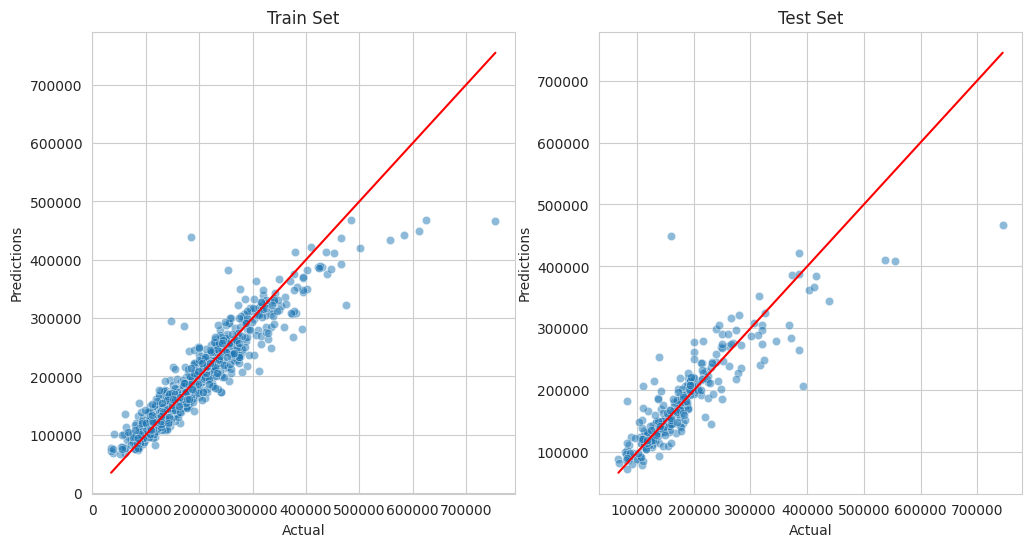

In [76]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In [77]:
pipeline_best = grid_search_pipelines[best_model_final].best_estimator_
pipeline_best

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['OverallQual', 'GrLivArea',
                                                     'GarageArea', 'YearBuilt',
                                                     'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(min_samples_leaf=4, random_state=0))])

---

### Evaluate model with best features on train and test sets

In [78]:
# Double checking performance scores with renamed best pipeline (pipeline_best)
regression_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_best)

Model Evaluation 

* Train Set
R2 Score: 0.881
Mean Absolute Error: 16744.33
Mean Squared Error: 729807752.971
Root Mean Squared Error: 27014.954


* Test Set
R2 Score: 0.765
Mean Absolute Error: 23102.253
Mean Squared Error: 1624752873.683
Root Mean Squared Error: 40308.223




---

## Pushing files to repo

In [79]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/regression_analysis/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/regression_analysis/v1'


### Train Set: features and target

In [80]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


In [81]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [82]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [83]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [84]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [85]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Saving best modelling pipeline as pkl file

In [87]:
pipeline_best

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['OverallQual', 'GrLivArea',
                                                     'GarageArea', 'YearBuilt',
                                                     'TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(min_samples_leaf=4, random_state=0))])

In [88]:
joblib.dump(value=pipeline_best, filename=f"{file_path}/pipeline_best.pkl")

['outputs/ml_pipeline/regression_analysis/v1/pipeline_best.pkl']

## Feature importance plot

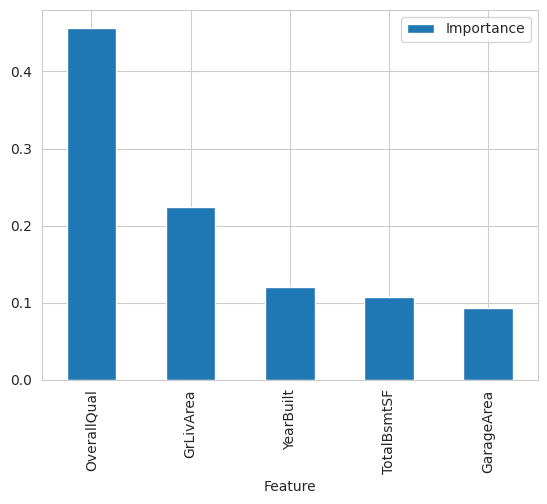

In [89]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/feature_importance.png', bbox_inches='tight')

---